## Setup

Before getting started, import the necessary packages:

In [7]:
#!python -m pip install tensorflow

In [1]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.2.0


In [2]:
#!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [3]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile


In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)
print(logdir)

C:\Users\fstri\AppData\Local\Temp\tmpouf891ww\tensorboard_logs


# FMNS: Try modeling our candles

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import h5py
import copy
import datetime
import ta
#import yfinance as yf
import tensorflow as tf
import tensorflow.compat.v2.feature_column as fc
from IPython.display import clear_output
import pyodbc

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, log_loss


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import ConvergenceWarning 
from sklearn import ensemble
# ConvergenceWarning('ignore')
# Do you wanna see?
verbose = True

import sys
sys.path.append('../')
#sys.path.append('...../')

from utils.data_extraction import load_data_final,load_data_and_save
from utils.data_cleaning import HFDataCleaning
from utils.generate_features import candleCreateNP_vect_final,\
                                    generateFeatures_final,\
                                    generateFeatures_multi_v1

from utils.preprocessing_features_and_labels import extract_labels,\
                                                    align_features_and_labels,\
                                                    pre_processing_initial,\
                                                    pre_processing_extended,\
                                                    pre_processing,\
                                                    extract_labels_multi,\
                                                    align_features_and_labels_multi

from utils.models import make_input_fn
from utils.models import performanceTesting,scoreFunction
from utils.plotting import plot_confusion_matrix

In [160]:
# Do we extract new data or read in?
readIn = True
# run load_data()
if readIn:
    
    # Listing the data files 
#     path = '../../../Google Drev/Thesis/Data/TAQ/AggregatedTAQ'
    path = 'F:/AggregatedTAQ/round3'
    datafiles = os.listdir(path)
    content = np.concatenate([['\n\n'],[str(j)+': '+i+'\n' for j,i in enumerate(datafiles) if 'csv' in i],['\n\n']])
    
    # Asking for user input
    file = input('Which one do you want to load? %s'%''.join(content))
    data = pd.read_csv(path + '/' + datafiles[int(file)],
                       header = None,
                       names=['open','high','low','close',
                              'spread_open','spread_high','spread_low','spread_close',
                              'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                              'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                              'Ticker'])
else:
    
    # print(os.listdir())
    try:
        path = 'a:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
    except:
        path = 't:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
        
    # Sample type
    data_sample = 'full' # or 'stable'
    # allFiles = os.listdir(path)
    # print(len(allFiles), allFiles[:5], allFiles[-5:])
    # print(allFiles[-10:])

    #dates = np.array(['2020040' + str(i) if i < 10 else '202004' + str(i) for i in np.arange(1,16)]).astype(int)
    dates = np.array(['20200501']).astype(int)#,'20200402','20200403','20200406','20200407'

    # Provide a list of tickers of interest
    
    tickers = sorted(['TSLA','FB'])#'MSFT'
    
    # Do we need data on trades, quotes or both?
    dataNeeded = 'quotes' # 'trades', 'quotes' or 'both'
    
    if dataNeeded == 'trades':
        tradeData = load_data_final(dates, tickers, dataNeeded, path, verbose)
    elif dataNeeded == 'quotes':
        quoteData = load_data_final(dates,
                                    tickers,
                                    dataNeeded,
                                    path,
                                    verbose,
                                    extract_candles = False,
                                    aggHorizon = 1,
                                    extra_features_from_quotes = None,
                                    data_sample = data_sample)
    elif dataNeeded == 'both':
        tradeData, quoteData = load_data_final(dates, tickers, dataNeeded, path, verbose)

Which one do you want to load? 

0: aggregateTAQ_10sec.csv
1: aggregateTAQ_30sec.csv
2: aggregateTAQ_60sec.csv


2


In [161]:
# add ticker as a multiindex or just groupby directly on date & ticker
data #.index

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  123.950  124.110  123.910  124.100         0.02         0.07   
         386  124.085  124.085  123.920  123.995         0.01         0.06   
         387  123.995  124.355  123.985  124.335         0.01         0.07   
         388  124.335  124.355  124.060  124.075         0.05         0.12   
         389  124.075  124.225  122.810  123.855         0.01         2.43   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.01          0.04           1.0          11.0   
         386        0.01          0.01           1.0           8.0   
         387        0.01          0.05           4.0          16.0   
         388        0.01          0.01           3.0           6.0   
         389        0.01          0.21           1.0          20.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            1.0           5.0           9.0   
         386          1.0            3.0           1.0           9.0   
         387          1.0            2.0           2.0          10.0   
         388          1.0            2.0           2.0          10.0   
         389          1.0            2.0           4.0          12.0   

              ofrsize_low  ofrsize_close Ticker  
20200501 0            1.0            4.0   AAPL  
         1            1.0            1.0   AAPL  
         2            1.0            1.0   AAPL  
         3            1.0            1.0   AAPL  
         4            1.0            1.0   AAPL  
...                   ...            ...    ...  
20200529 385          1.0            1.0    WMT  
         386          1.0            2.0    WMT  
         387          1.0            2.0    WMT  
         388          1.0            4.0    WMT  
         389          1.0            1.0    WMT  

[514800 rows x 17 columns]

In [162]:
for i, ticker in enumerate(data.Ticker.unique()):
    print(i, ticker)

0 AAPL
1 ABBV
2 ABT
3 AEP
4 AMT
5 APD
6 BA
7 BABA
8 BAC
9 BHP
10 BP
11 CCI
12 CHL
13 COST
14 CSGP
15 D
16 DIS
17 ECL
18 ENB
19 EXC
20 FB
21 FMX
22 GOOG
23 IDU
24 INTC
25 IYC
26 IYE
27 IYG
28 IYH
29 IYJ
30 IYK
31 IYM
32 IYR
33 IYW
34 IYZ
35 JNJ
36 KO
37 LFC
38 LIN
39 LMT
40 MA
41 MCD
42 MSFT
43 NKE
44 NVDA
45 NVS
46 PBR
47 PEP
48 PFE
49 PLD
50 PSA
51 PTR
52 PYPL
53 RTX
54 SHW
55 SNP
56 SO
57 SRE
58 T
59 TM
60 TSLA
61 TSM
62 UNP
63 UPS
64 V
65 WMT


In [163]:
data[data.Ticker=='TSLA']

open     high      low    close  spread_open  spread_high  \
20200501 0    755.140  762.530  753.500  762.215         1.72         4.42   
         1    762.265  763.480  755.065  757.875         1.47         5.91   
         2    757.875  760.225  756.795  758.915         1.33         3.58   
         3    758.920  764.795  755.985  764.475         0.82         3.20   
         4    764.475  772.745  764.130  770.750         1.05         2.98   
...               ...      ...      ...      ...          ...          ...   
20200529 385  833.135  834.920  833.060  834.560         0.47         0.70   
         386  834.635  834.970  834.060  834.160         0.31         0.54   
         387  834.170  834.175  832.420  832.610         0.26         0.64   
         388  832.615  833.965  832.615  833.900         0.19         0.76   
         389  833.895  834.395  833.780  834.145         0.19         0.47   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.02          1.37           1.0           7.0   
         1          0.13          1.33           1.0           7.0   
         2          0.01          0.81           2.0          10.0   
         3          0.01          1.05           1.0          10.0   
         4          0.01          0.84           1.0          20.0   
...                  ...           ...           ...           ...   
20200529 385        0.04          0.46           1.0           6.0   
         386        0.02          0.24           1.0           6.0   
         387        0.03          0.20           3.0          16.0   
         388        0.04          0.20           1.0          10.0   
         389        0.01          0.17           1.0         120.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0            1.0           5.0          26.0   
         1            1.0            2.0          15.0          15.0   
         2            1.0            1.0           2.0           7.0   
         3            1.0            1.0           4.0          30.0   
         4            1.0            1.0          31.0          31.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            3.0           1.0         113.0   
         386          1.0            3.0           1.0          87.0   
         387          1.0            1.0           1.0          26.0   
         388          1.0            1.0           2.0          31.0   
         389          1.0           90.0           2.0          53.0   

              ofrsize_low  ofrsize_close Ticker  
20200501 0            1.0            2.0   TSLA  
         1            1.0            1.0   TSLA  
         2            1.0            1.0   TSLA  
         3            1.0           30.0   TSLA  
         4            1.0            1.0   TSLA  
...                   ...            ...    ...  
20200529 385          1.0            1.0   TSLA  
         386          1.0            1.0   TSLA  
         387          1.0            2.0   TSLA  
         388          1.0           29.0   TSLA  
         389          1.0           28.0   TSLA  

[7800 rows x 17 columns]

In [272]:
## Works only for two classes (by using median)
def extract_labels_multi(data = None,
                        classes = 5,
                        group_style = 'equal',
                        global_median=None):

   # returns = ((data.T[-1][1:]/data.T[-1][0:-1])-1)
    returns = ((data[1:] / data[:-1]) -1)
    # If returns are exact zero, perhaps because there hasn't been any price updates over a candle, we add a little bit of noise, to ensure that the labels are evenly distributed.
    # if noise:
        # returns[returns==0] = np.random.normal(0,1,sum(returns==0))/1000000

    labels = np.zeros(returns.shape[0])

    if group_style == 'equal':
        # if splits is None:
            # splits = np.array_split(np.sort(returns),classes)

        # for i in np.arange(classes):

        labels[returns > global_median] = 1
        labels[returns <= global_median] = 0

    elif group_style != 'equal':
        raise ValueError(f'group_style {group_style} not implemented')

    return labels #, returns, [thresholdsMin, thresholdsMax]


def align_features_and_labels_multi(price_candles,
                                    all_features,
                                    prediction_horizon,
                                    n_feature_lags,
                                    n_classes,
                                    safe_burn_in = False,
                                    data_sample = 'full',
                                    splitType='global',
                                    noise = True):

    all_burned_in_features = pd.DataFrame()
    all_labels = pd.DataFrame()
    if splitType.lower() == 'global':
        # Making the splits for the labels based on all tickers
        # returns = ((price_candles['close'].values[1:] / price_candles['close'].values[:-1]) -1) * 100
        returns = np.concatenate([((price_candles[price_candles.Ticker==ticker]['close'].values[1:]/\
                         price_candles[price_candles.Ticker==ticker]['close'].values[:-1])-1) for ticker\
                          in price_candles.Ticker.unique()])
        if noise:
            returns[returns==0] = np.random.normal(0,1,sum(returns==0))/1000000

        # splits = np.array_split(np.sort(returns),n_classes)
        global_median = np.median(returns)
        
    for ticker_iter, ticker_name in enumerate(all_features.ticker.unique()):
        ticker_features = all_features[all_features.ticker==ticker_name].copy(deep=True)
        # removing the "ticker" variable from ticker_features as np.isnan() does not like non-numericals
        #ticker_features = ticker_features.iloc[:, ticker_features.columns != 'ticker']
        ticker_features.drop('ticker', axis=1, inplace=True)
        # extract first 4 columns as the lag0 or raw OHLC prices (used for labelling)
        ticker_prices = price_candles[price_candles.Ticker==ticker_name]['close'].values # candles.iloc[:, :4].values

        if not safe_burn_in:
            assert data_sample == 'full'
            # we assume data_sample is full and that we can continue features from yesterday's values.
            # that we have a single burn-in at the beginning and that's it

            # get first index that has no NaNs (the sum checks for True across columns, we look for sum == 0 and where that is first True)
            burned_in_idx = np.where((np.sum(np.isnan(ticker_features.values), axis=1) == 0) == True)[0][0]

            # calculate end-point cut-off to match with labels
            end_point_cut = max(prediction_horizon, n_feature_lags + 1)

            # slice away the observations used for burn-in (taking off 1 at the end to match with labels [slice off "prediction_horizon"])
            burned_in_features = ticker_features.iloc[burned_in_idx : -end_point_cut, :] #.reset_index(drop=True) # features[burned_in_idx:] latter is sligthly faster but maybe not as precise

            # slice away the burned-in indices from labels
            labels = extract_labels_multi(data = ticker_prices[(burned_in_idx+n_feature_lags):],
                                          classes = n_classes,
                                          group_style = 'equal',
                                          global_median = global_median)
            # labels, returns, thresholds = extract_labels(data = candles[burned_in_idx + n_feature_lags : , :],
            #                                             classes = n_classes, group_style = 'equal')

            # check if there are remaining NaNs are burn-in (means error)
            remaining_nans = np.where(np.isnan(burned_in_features.values))[0].size
            if remaining_nans > 0:
                raise ValueError('Had NaN in burned_in_features after burn-in')

        burned_in_features['ticker'] = ticker_name
        all_burned_in_features = pd.concat([all_burned_in_features, burned_in_features])
        all_labels = pd.concat([all_labels, pd.Series(labels)])
        print(ticker_name + " done")

    return all_burned_in_features, all_labels.reset_index(drop=True) # call the function as X, y = align_features_and_labels(.) if you like

### Exploratory look at all returns

In [273]:
price_candles = data[['open','high','low','close','Ticker']]
returns = np.concatenate([((price_candles[price_candles.Ticker==ticker]['close'].values[1:]/\
                 price_candles[price_candles.Ticker==ticker]['close'].values[:-1])-1) for ticker\
                  in price_candles.Ticker.unique()])

In [274]:
returns.shape

(514734,)

In [275]:
pd.Series(returns).describe()

count    514734.000000
mean          0.000008
std           0.001247
min          -0.053926
25%          -0.000417
50%           0.000000
75%           0.000417
max           0.090716
dtype: float64

In [276]:
out, bins = pd.qcut(pd.Series(returns), q=20, retbins=True)

In [277]:
bins

array([-5.39263482e-02, -1.43218329e-03, -9.74207188e-04, -7.19856361e-04,
       -5.39459123e-04, -4.17257782e-04, -3.07385260e-04, -2.12154096e-04,
       -1.18686473e-04, -2.31327798e-05,  0.00000000e+00,  2.74827958e-05,
        1.22039856e-04,  2.14829405e-04,  3.08834080e-04,  4.16679688e-04,
        5.35117057e-04,  7.13068796e-04,  9.66272267e-04,  1.42857143e-03,
        9.07158044e-02])

(-0.002, 0.002)

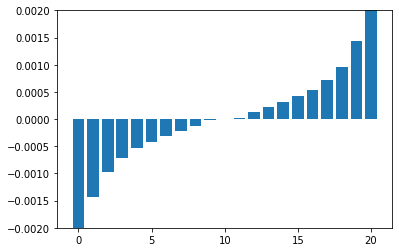

In [278]:
plt.bar(range(21), bins)
plt.ylim((-0.002, 0.002))

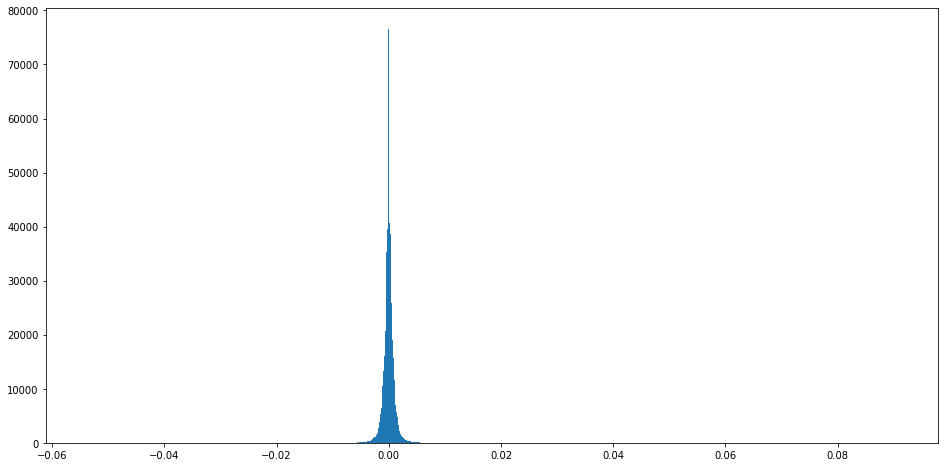

In [279]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
ax.hist(returns, bins=1000)
plt.show()

### Repeat with noise

In [280]:
returns_noise = np.concatenate([((price_candles[price_candles.Ticker==ticker]['close'].values[1:]/\
                 price_candles[price_candles.Ticker==ticker]['close'].values[:-1])-1) for ticker\
                  in price_candles.Ticker.unique()])

In [281]:
tt = (np.random.normal(0,1,sum(returns_noise==0))/1000000)
pd.Series(tt).describe()

count    4.661000e+04
mean     2.888841e-09
std      1.000296e-06
min     -4.035643e-06
25%     -6.716704e-07
50%      4.901446e-09
75%      6.756380e-07
max      4.156107e-06
dtype: float64

In [282]:
sum(returns_noise==0)

46610

In [283]:
returns_noise[returns_noise==0] = np.random.normal(0,1,sum(returns_noise==0))/1000000

In [284]:
returns_noise.shape

(514734,)

In [285]:
pd.Series(returns_noise).describe()

count    5.147340e+05
mean     8.465802e-06
std      1.247118e-03
min     -5.392635e-02
25%     -4.172578e-04
50%      3.461898e-08
75%      4.166797e-04
max      9.071580e-02
dtype: float64

In [286]:
pd.Series(returns).describe()

count    514734.000000
mean          0.000008
std           0.001247
min          -0.053926
25%          -0.000417
50%           0.000000
75%           0.000417
max           0.090716
dtype: float64

In [287]:
# Ok, so everything except median seems ok

In [288]:
out, bins = pd.qcut(pd.Series(returns_noise), q=20, retbins=True)

In [289]:
bins

array([-5.39263482e-02, -1.43218329e-03, -9.74207188e-04, -7.19856361e-04,
       -5.39459123e-04, -4.17257782e-04, -3.07385260e-04, -2.12154096e-04,
       -1.18686473e-04, -2.31327798e-05,  3.46189776e-08,  2.74827958e-05,
        1.22039856e-04,  2.14829405e-04,  3.08834080e-04,  4.16679688e-04,
        5.35117057e-04,  7.13068796e-04,  9.66272267e-04,  1.42857143e-03,
        9.07158044e-02])

(-0.002, 0.002)

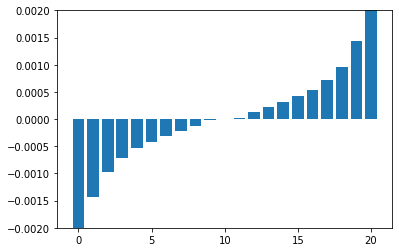

In [290]:
plt.bar(range(21), bins)
plt.ylim((-0.002, 0.002))

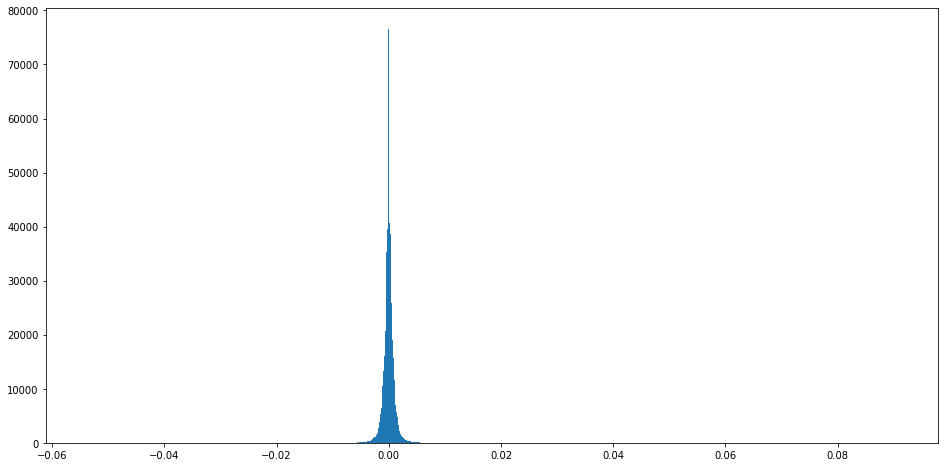

In [291]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
ax.hist(returns_noise, bins=1000)
plt.show()

- Looks like no visual difference when adding noise, that is good (but also no need for it)

### Let's split them up for binary classification

In [292]:
q_ret = pd.qcut(pd.Series(returns), q=2, labels=False, retbins=False)
q_ret

0         0
1         0
2         1
3         1
4         0
         ..
514729    1
514730    0
514731    1
514732    0
514733    0
Length: 514734, dtype: int64

In [293]:
q_ret_noise = pd.qcut(pd.Series(returns_noise), q=2, labels=False, retbins=False)
q_ret_noise

0         0
1         0
2         1
3         1
4         0
         ..
514729    1
514730    0
514731    1
514732    0
514733    0
Length: 514734, dtype: int64

In [294]:
sum(q_ret), sum(q_ret_noise)

(234754, 257367)

In [295]:
sum(q_ret == 0), sum(q_ret == 1), sum(q_ret_noise == 0), sum(q_ret_noise == 1)

(279980, 234754, 257367, 257367)

In [296]:
# Compare that to the returns series with ge and leq median:
sum(returns > pd.Series(returns).median()), sum(returns <= pd.Series(returns).median())

(234754, 279980)

In [297]:
sum(returns_noise > pd.Series(returns_noise).median()), sum(returns_noise <= pd.Series(returns_noise).median())

(257367, 257367)

- Using the noised returns and splitting either on (noised) median or using .qcut() seems good

In [298]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  123.950  124.110  123.910  124.100         0.02         0.07   
         386  124.085  124.085  123.920  123.995         0.01         0.06   
         387  123.995  124.355  123.985  124.335         0.01         0.07   
         388  124.335  124.355  124.060  124.075         0.05         0.12   
         389  124.075  124.225  122.810  123.855         0.01         2.43   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.01          0.04           1.0          11.0   
         386        0.01          0.01           1.0           8.0   
         387        0.01          0.05           4.0          16.0   
         388        0.01          0.01           3.0           6.0   
         389        0.01          0.21           1.0          20.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            1.0           5.0           9.0   
         386          1.0            3.0           1.0           9.0   
         387          1.0            2.0           2.0          10.0   
         388          1.0            2.0           2.0          10.0   
         389          1.0            2.0           4.0          12.0   

              ofrsize_low  ofrsize_close Ticker  
20200501 0            1.0            4.0   AAPL  
         1            1.0            1.0   AAPL  
         2            1.0            1.0   AAPL  
         3            1.0            1.0   AAPL  
         4            1.0            1.0   AAPL  
...                   ...            ...    ...  
20200529 385          1.0            1.0    WMT  
         386          1.0            2.0    WMT  
         387          1.0            2.0    WMT  
         388          1.0            4.0    WMT  
         389          1.0            1.0    WMT  

[514800 rows x 17 columns]

In [299]:
medi = pd.Series(returns_noise).median()
res = [0, 0, 0, 0]
for ticker in price_candles.Ticker.unique():
    
    data1 = price_candles[price_candles.Ticker==ticker]['close'].values
    ret = data1[1:] / data1[:-1] - 1
    
    # the issue arises when the noise (below here) is missing inside the label-loop, 
    # and this could still be better, as the median was calculated outside the 
    # label-loop using different std. normal pushes
    ret[ret==0] = np.random.normal(0,1,sum(ret==0))/1000000 
    
    print(ticker,  len(data1),  len(ret), sum(ret > medi), sum(ret <= medi))
    res[0] += len(data1)
    res[1] += len(ret)
    res[2] += sum(ret > medi)
    res[3] += sum(ret <= medi)
res    

AAPL 7800 7799 3973 3826
ABBV 7800 7799 3947 3852
ABT 7800 7799 3917 3882
AEP 7800 7799 3830 3969
AMT 7800 7799 3923 3876
APD 7800 7799 3878 3921
BA 7800 7799 3922 3877
BABA 7800 7799 3880 3919
BAC 7800 7799 3881 3918
BHP 7800 7799 3924 3875
BP 7800 7799 3819 3980
CCI 7800 7799 3935 3864
CHL 7800 7799 3859 3940
COST 7800 7799 3916 3883
CSGP 7800 7799 3927 3872
D 7800 7799 3870 3929
DIS 7800 7799 3953 3846
ECL 7800 7799 4014 3785
ENB 7800 7799 3899 3900
EXC 7800 7799 3902 3897
FB 7800 7799 4001 3798
FMX 7800 7799 3803 3996
GOOG 7800 7799 4020 3779
IDU 7800 7799 3789 4010
INTC 7800 7799 3895 3904
IYC 7800 7799 3951 3848
IYE 7800 7799 3822 3977
IYG 7800 7799 3961 3838
IYH 7800 7799 3943 3856
IYJ 7800 7799 3977 3822
IYK 7800 7799 3892 3907
IYM 7800 7799 3939 3860
IYR 7800 7799 3858 3941
IYW 7800 7799 4054 3745
IYZ 7800 7799 3869 3930
JNJ 7800 7799 3841 3958
KO 7800 7799 3860 3939
LFC 7800 7799 3754 4045
LIN 7800 7799 3964 3835
LMT 7800 7799 3909 3890
MA 7800 7799 3947 3852
MCD 7800 7799 38

[514800, 514734, 257223, 257511]

# Concerns with the noise:
- We are trying to split up a large bunch of zero returns, i.e. they actually have the same return in reality
- By splitting them, we put one half as negative return labels, one half as positive labels
- So we are contaminating (adding noise in the bad way) for our classifier - we are giving it feature vectors that actually lead to zero return but we tell it through the label that it leads to negative return

# Conclusion: FRST thinks we should go with:
- class 0: x < median (negative return)
- class 1: x >= median (zero or positive return)
- As zero return is arguably more related to positive than negative return

# Alternative:
- Remove all zero returns from the training data
- This might be bad for backtesting though (at least in-sample backtesting, out-of-sample could be fine)

### Try running labels separately

In [300]:
# np.concatenate([((price_candles[price_candles.Ticker==ticker]['close'].values[1:]/\
#                  price_candles[price_candles.Ticker==ticker]['close'].values[:-1])-1) for ticker\
#                   in price_candles.Ticker.unique()])

medi = pd.Series(returns_noise).median()
y_sum, y_0, y_1 = 0, 0, 0

for ticker in price_candles.Ticker.unique():

    print(ticker)
    y = extract_labels_multi(data = price_candles[price_candles.Ticker==ticker]['close'].values,
                            classes = 2,
                            group_style = 'equal',
                            global_median=medi)
    
    print(y.shape, sum(y == 0), sum(y == 1))
    y_sum += y.shape[0]
    y_0 += sum(y == 0)
    y_1 += sum(y == 1)
    
y_sum, y_0, y_1 # 514734, 280213, 234521

AAPL
(7799,) 3868 3931
ABBV
(7799,) 3976 3823
ABT
(7799,) 4030 3769
AEP
(7799,) 4097 3702
AMT
(7799,) 3935 3864
APD
(7799,) 4027 3772
BA
(7799,) 3921 3878
BABA
(7799,) 3993 3806
BAC
(7799,) 4746 3053
BHP
(7799,) 4500 3299
BP
(7799,) 4958 2841
CCI
(7799,) 3941 3858
CHL
(7799,) 4964 2835
COST
(7799,) 3943 3856
CSGP
(7799,) 4162 3637
D
(7799,) 4064 3735
DIS
(7799,) 3935 3864
ECL
(7799,) 3862 3937
ENB
(7799,) 4561 3238
EXC
(7799,) 4385 3414
FB
(7799,) 3852 3947
FMX
(7799,) 4313 3486
GOOG
(7799,) 3807 3992
IDU
(7799,) 4090 3709
INTC
(7799,) 4242 3557
IYC
(7799,) 3943 3856
IYE
(7799,) 4818 2981
IYG
(7799,) 3964 3835
IYH
(7799,) 3957 3842
IYJ
(7799,) 3953 3846
IYK
(7799,) 4111 3688
IYM
(7799,) 4029 3770
IYR
(7799,) 4179 3620
IYW
(7799,) 3819 3980
IYZ
(7799,) 5150 2649
JNJ
(7799,) 4073 3726
KO
(7799,) 4557 3242
LFC
(7799,) 7059 740
LIN
(7799,) 3956 3843
LMT
(7799,) 3947 3852
MA
(7799,) 3907 3892
MCD
(7799,) 3991 3808
MSFT
(7799,) 3919 3880
NKE
(7799,) 3990 3809
NVDA
(7799,) 3895 3904
NVS
(7799

(514734, 280213, 234521)

# I doubt we will have this issue with uneven number of classes, try with 3:

In [318]:
n_classes = 3
q_ret = pd.qcut(pd.Series(returns), q=n_classes, labels=False, retbins=False)
q_ret

0         0
1         0
2         2
3         2
4         0
         ..
514729    2
514730    0
514731    2
514732    0
514733    0
Length: 514734, dtype: int64

In [319]:
q_ret_noise = pd.qcut(pd.Series(returns_noise), q=n_classes, labels=False, retbins=False)
q_ret_noise

0         0
1         0
2         2
3         2
4         0
         ..
514729    2
514730    0
514731    2
514732    0
514733    0
Length: 514734, dtype: int64

In [320]:
[sum(q_ret == class_i) for class_i in range(n_classes)], [sum(q_ret_noise == class_i) for class_i in range(n_classes)]

([171578, 171578, 171578], [171578, 171578, 171578])

- so no need for noise here, as all the zeros go into their own middle class ala "low negative + zero + low positive returns"

# 4 classes might be about as bad as binary

In [314]:
n_classes = 4
q_ret = pd.qcut(pd.Series(returns), q=n_classes, labels=False, retbins=False)
q_ret

0         0
1         0
2         3
3         3
4         0
         ..
514729    3
514730    0
514731    3
514732    0
514733    0
Length: 514734, dtype: int64

In [315]:
q_ret_noise = pd.qcut(pd.Series(returns_noise), q=n_classes, labels=False, retbins=False)
q_ret_noise

0         0
1         0
2         3
3         3
4         0
         ..
514729    3
514730    0
514731    3
514732    0
514733    0
Length: 514734, dtype: int64

In [316]:
[sum(q_ret == class_i) for class_i in range(n_classes)], [sum(q_ret_noise == class_i) for class_i in range(n_classes)]

([128685, 151295, 106070, 128684], [128685, 128682, 128683, 128684])

# Let's also check 5 classes

In [311]:
n_classes = 5
q_ret = pd.qcut(pd.Series(returns), q=n_classes, labels=False, retbins=False)
q_ret

0         0
1         0
2         4
3         4
4         0
         ..
514729    4
514730    0
514731    4
514732    0
514733    0
Length: 514734, dtype: int64

In [312]:
q_ret_noise = pd.qcut(pd.Series(returns_noise), q=n_classes, labels=False, retbins=False)
q_ret_noise

0         0
1         0
2         4
3         4
4         0
         ..
514729    4
514730    0
514731    4
514732    0
514733    0
Length: 514734, dtype: int64

In [313]:
[sum(q_ret == class_i) for class_i in range(n_classes)], [sum(q_ret_noise == class_i) for class_i in range(n_classes)]

([102947, 102947, 102946, 102948, 102946],
 [102947, 102947, 102946, 102948, 102946])

# Work more on the global returns df to add noise outside loop and pass on t

In [199]:
returns = []
tickers = []
for ticker in price_candles.Ticker.unique():
    
    ticker_returns = (price_candles[price_candles.Ticker==ticker]['close'].values[1:]/\
                         price_candles[price_candles.Ticker==ticker]['close'].values[:-1]) - 1
    ticker_names = [ticker for i in range(len(ticker_returns))]
    
    returns.append(ticker_returns)
    tickers.append(ticker_names)

# concatenate returns and add noise    
returns = np.concatenate(returns)
returns[returns==0] = np.random.normal(0,1,sum(returns==0))/1000000

tickers = np.concatenate(tickers)


In [200]:
returns = pd.DataFrame({'returns': returns, 'Ticker': tickers})
returns

,returns,Ticker
0,-0.000830,AAPL
1,-0.001522,AAPL
2,0.001785,AAPL
3,0.004237,AAPL
4,-0.000809,AAPL
...,...,...
514729,0.001210,WMT
514730,-0.000846,WMT
514731,0.002742,WMT
514732,-0.002091,WMT


In [201]:
returns_noise
# looks consistent, great

array([-0.0008297 , -0.00152239,  0.0017846 , ...,  0.00274205,
       -0.00209112, -0.00177312])

In [202]:
returns[returns.Ticker=='AAPL']['returns'].values

array([-0.0008297 , -0.00152239,  0.0017846 , ...,  0.00192884,
       -0.00245727, -0.00236918])

# Let's update the functions

In [203]:
## Works only for two classes (by using median)
def extract_labels_multi(data = None,
                        classes = 5,
                        group_style = 'equal',
                        splits=None):
    
    # this version takes data in a direct returns for a specific ticker

    if group_style == 'equal':
        # if splits is None:
            # splits = np.array_split(np.sort(returns),classes)

        # for i in np.arange(classes):

        #labels[returns > global_median] = 1
        #labels[returns <= global_median] = 0
        
        labels = pd.cut(data, bins=splits, labels=False, right=False, include_lowest=True)
        
        # we need right=False (open right-handside in split interval) to get median into the positive class

    elif group_style != 'equal':
        raise ValueError(f'group_style {group_style} not implemented')

    return labels #, returns, [thresholdsMin, thresholdsMax]


def align_features_and_labels_multi(price_candles,
                                    all_features,
                                    prediction_horizon,
                                    n_feature_lags,
                                    n_classes,
                                    safe_burn_in = False,
                                    data_sample = 'full',
                                    splitType='global',
                                    noise = True):

    all_burned_in_features = pd.DataFrame()
    all_labels = pd.DataFrame()
    
    if splitType.lower() == 'global':
        # Making the splits for the labels based on all tickers
        # returns = ((price_candles['close'].values[1:] / price_candles['close'].values[:-1]) -1) * 100
#         returns = np.concatenate([((price_candles[price_candles.Ticker==ticker]['close'].values[1:]/\
#                          price_candles[price_candles.Ticker==ticker]['close'].values[:-1])-1) for ticker\
#                           in price_candles.Ticker.unique()])

        returns = []
        tickers = []
        for ticker in price_candles.Ticker.unique():

            ticker_returns = (price_candles[price_candles.Ticker==ticker]['close'].values[1:]/\
                                 price_candles[price_candles.Ticker==ticker]['close'].values[:-1]) - 1
            ticker_names = [ticker for i in range(len(ticker_returns))]

            returns.append(ticker_returns)
            tickers.append(ticker_names)

        # concatenate returns and add noise    
        returns = np.concatenate(returns)
        if noise:
            returns[returns==0] = np.random.normal(0,1,sum(returns==0))/1000000

        tickers = np.concatenate(tickers)

        _, splits = pd.qcut(returns, q=n_classes, labels=False, retbins=True)
        print(splits)
        
        returns = pd.DataFrame({'returns': returns, 'Ticker': tickers})
        
        
        
    for ticker_iter, ticker_name in enumerate(all_features.ticker.unique()):
        ticker_features = all_features[all_features.ticker==ticker_name].copy(deep=True)
        # removing the "ticker" variable from ticker_features as np.isnan() does not like non-numericals
        #ticker_features = ticker_features.iloc[:, ticker_features.columns != 'ticker']
        ticker_features.drop('ticker', axis=1, inplace=True)
        # extract first 4 columns as the lag0 or raw OHLC prices (used for labelling)
        #ticker_prices = price_candles[price_candles.Ticker==ticker_name]['close'].values # candles.iloc[:, :4].values
        ticker_returns = returns[returns.Ticker==ticker_name]['returns'].values

        if not safe_burn_in:
            assert data_sample == 'full'
            # we assume data_sample is full and that we can continue features from yesterday's values.
            # that we have a single burn-in at the beginning and that's it

            # get first index that has no NaNs (the sum checks for True across columns, we look for sum == 0 and where that is first True)
            burned_in_idx = np.where((np.sum(np.isnan(ticker_features.values), axis=1) == 0) == True)[0][0]

            # calculate end-point cut-off to match with labels
            end_point_cut = max(prediction_horizon, n_feature_lags + 1)

            # slice away the observations used for burn-in (taking off 1 at the end to match with labels [slice off "prediction_horizon"])
            burned_in_features = ticker_features.iloc[burned_in_idx : -end_point_cut, :] #.reset_index(drop=True) # features[burned_in_idx:] latter is sligthly faster but maybe not as precise

            # slice away the burned-in indices from labels
            labels = extract_labels_multi(data = ticker_returns[(burned_in_idx+n_feature_lags):],
                                          classes = n_classes,
                                          group_style = 'equal',
                                          splits = splits)
            # labels, returns, thresholds = extract_labels(data = candles[burned_in_idx + n_feature_lags : , :],
            #                                             classes = n_classes, group_style = 'equal')

            # check if there are remaining NaNs are burn-in (means error)
            remaining_nans = np.where(np.isnan(burned_in_features.values))[0].size
            if remaining_nans > 0:
                raise ValueError('Had NaN in burned_in_features after burn-in')

        burned_in_features['ticker'] = ticker_name
        all_burned_in_features = pd.concat([all_burned_in_features, burned_in_features])
        all_labels = pd.concat([all_labels, pd.Series(labels)])
        print(ticker_name + " done")

    return all_burned_in_features, all_labels.reset_index(drop=True) # call the function as X, y = align_features_and_labels(.) if you like

In [204]:
# Test functions:

returns = []
tickers = []
noise = True
n_classes = 2
for ticker in price_candles.Ticker.unique():

    ticker_returns = (price_candles[price_candles.Ticker==ticker]['close'].values[1:]/\
                         price_candles[price_candles.Ticker==ticker]['close'].values[:-1]) - 1
    ticker_names = [ticker for i in range(len(ticker_returns))]

    returns.append(ticker_returns)
    tickers.append(ticker_names)

# concatenate returns and add noise    
returns = np.concatenate(returns)
if noise:
    returns[returns==0] = np.random.normal(0,1,sum(returns==0))/1000000

tickers = np.concatenate(tickers)

_, splits = pd.qcut(returns, q=n_classes, labels=False, retbins=True)
print(splits)

returns = pd.DataFrame({'returns': returns, 'Ticker': tickers})
        
# --------------


    
    
#medi = pd.Series(returns_noise).median()
y_sum, y_0, y_1 = 0, 0, 0
yy = []

for ticker in price_candles.Ticker.unique():
    
    ticker_returns = returns[returns.Ticker==ticker]['returns'].values

    print(ticker)
    y = extract_labels_multi(data = ticker_returns,
                            classes = 2,
                            group_style = 'equal',
                            splits = splits)
    
    print(y.shape, sum(y == 0), sum(y == 1))
    y_sum += y.shape[0]
    y_0 += sum(y == 0)
    y_1 += sum(y == 1)
    yy.append(y)

yy = np.concatenate(yy)
y_sum, y_0, y_1 # 514734, 280213, 234521


# with noise & right == True in pd.cut():
# (514734, 257367, 257367)

# without noise & right == True in pd.cut()
# (514734, 279980, 234754)

# with noise & right == False in pd.cut():
# (514734, 257367, 257366)

# without noise & right == False in pd.cut()
# (514734, 233370, 281363)

[-5.39263482e-02  1.66689841e-08  9.07158044e-02]
AAPL
(7799,) 3829 3970
ABBV
(7799,) 3841 3958
ABT
(7799,) 3887 3912
AEP
(7799,) 3978 3821
AMT
(7799,) 3872 3927
APD
(7799,) 3929 3870
BA
(7799,) 3877 3922
BABA
(7799,) 3929 3870
BAC
(7799,) 3900 3899
BHP
(7799,) 3899 3900
BP
(7799,) 3986 3813
CCI
(7799,) 3876 3923
CHL
(7799,) 3944 3855
COST
(7799,) 3889 3910
CSGP
(7799,) 3852 3947
D
(7799,) 3918 3881
DIS
(7799,) 3831 3968
ECL
(7799,) 3779 4020
ENB
(7799,) 3922 3877
EXC
(7799,) 3921 3878
FB
(7799,) 3792 4007
FMX
(7799,) 3936 3863
GOOG
(7799,) 3776 4023
IDU
(7799,) 4011 3788
INTC
(7799,) 3910 3889
IYC
(7799,) 3849 3950
IYE
(7799,) 3941 3858
IYG
(7799,) 3837 3962
IYH
(7799,) 3852 3947
IYJ
(7799,) 3803 3996
IYK
(7799,) 3897 3902
IYM
(7799,) 3860 3939
IYR
(7799,) 3908 3891
IYW
(7799,) 3751 4048
IYZ
(7799,) 3963 3836
JNJ
(7799,) 3972 3827
KO
(7799,) 3925 3874
LFC
(7799,) 3974 3825
LIN
(7799,) 3839 3960
LMT
(7799,) 3889 3910
MA
(7799,) 3864 3935
MCD
(7799,) 3895 3904
MSFT
(7799,) 3827 3972
NKE

(514734, 257367, 257366)

In [205]:
returns.sort_values('returns')

,returns,Ticker
47183,-0.053926,BA
434794,-0.049716,SNP
429334,-0.046512,SNP
114645,-0.043936,CSGP
294412,-0.043818,LFC
...,...,...
74480,0.068649,BHP
82279,0.069890,BP
363043,0.086672,PBR
407107,0.089332,PYPL


In [206]:
returns.iloc[364993]

returns    0.0907158
Ticker           PBR
Name: 364993, dtype: object

In [207]:
sum(returns.isnull()['returns'])

0

In [208]:
sum(np.isnan(yy))

1

In [209]:
yy[364993]

nan

In [210]:
yy[np.where(np.isnan(yy))] = 1

In [211]:
sum(np.isnan(yy))

0

In [212]:
yy[364993]

1.0

### fix and re-run

In [239]:
## Works only for two classes (by using median)
def extract_labels_multi(data = None,
                        classes = 5,
                        group_style = 'equal',
                        splits=None):
    
    # this version takes data in a direct returns for a specific ticker

    if group_style == 'equal':
        # if splits is None:
            # splits = np.array_split(np.sort(returns),classes)

        # for i in np.arange(classes):

        #labels[returns > global_median] = 1
        #labels[returns <= global_median] = 0
        
        labels = pd.cut(data, bins=splits, labels=False, right=False, include_lowest=True)
        
        # we need right=False (open right-handside in split interval) to get median into the positive class
        # this makes the last point nan, we fix it here
        if sum(np.isnan(labels)) > 0:
            print(f'Number of NaNs in label: {sum(np.isnan(labels))}. 1 is expected')
            print(f'Returns that lead to NaNs in label: {data[np.where(np.isnan(labels))]}')
            assert sum(np.isnan(labels)) <= 1, "There should be max 1 NaN"
            if data[np.where(np.isnan(labels))] >= splits[-1]:
                labels[np.where(np.isnan(labels))] = classes - 1 # assign last label id
            else:
                print(data[np.where(np.isnan(labels))], splits[-1])
                raise ValueError('There is a label NaN where its underlying return is not max of dataset, which it should be')        

    elif group_style != 'equal':
        raise ValueError(f'group_style {group_style} not implemented')

    return labels #, returns, [thresholdsMin, thresholdsMax]

In [214]:
# Re-test functions:

returns = []
tickers = []
noise = False
n_classes = 2
for ticker in price_candles.Ticker.unique():

    ticker_returns = (price_candles[price_candles.Ticker==ticker]['close'].values[1:]/\
                         price_candles[price_candles.Ticker==ticker]['close'].values[:-1]) - 1
    ticker_names = [ticker for i in range(len(ticker_returns))]

    returns.append(ticker_returns)
    tickers.append(ticker_names)

# concatenate returns and add noise    
returns = np.concatenate(returns)
if noise:
    returns[returns==0] = np.random.normal(0,1,sum(returns==0))/1000000

tickers = np.concatenate(tickers)

_, splits = pd.qcut(returns, q=n_classes, labels=False, retbins=True)
print(splits)

returns = pd.DataFrame({'returns': returns, 'Ticker': tickers})
        
# --------------


    
    
#medi = pd.Series(returns_noise).median()
y_sum, y_0, y_1 = 0, 0, 0
yy = []

for ticker in price_candles.Ticker.unique():
    
    ticker_returns = returns[returns.Ticker==ticker]['returns'].values

    print(ticker)
    y = extract_labels_multi(data = ticker_returns,
                            classes = 2,
                            group_style = 'equal',
                            splits = splits)
    
    print(y.shape, sum(y == 0), sum(y == 1))
    y_sum += y.shape[0]
    y_0 += sum(y == 0)
    y_1 += sum(y == 1)
    yy.append(y)

yy = np.concatenate(yy)
y_sum, y_0, y_1 # 514734, 280213, 234521


# with noise & right == False in pd.cut():
# (514734, 257367, 257367)

# without noise & right == False in pd.cut()
# (514734, 233370, 281364)

[-0.05392635  0.          0.0907158 ]
AAPL
(7799,) 3777 4022
ABBV
(7799,) 3696 4103
ABT
(7799,) 3711 4088
AEP
(7799,) 3840 3959
AMT
(7799,) 3808 3991
APD
(7799,) 3820 3979
BA
(7799,) 3822 3977
BABA
(7799,) 3849 3950
BAC
(7799,) 3049 4750
BHP
(7799,) 3258 4541
BP
(7799,) 2967 4832
CCI
(7799,) 3799 4000
CHL
(7799,) 2950 4849
COST
(7799,) 3810 3989
CSGP
(7799,) 3567 4232
D
(7799,) 3767 4032
DIS
(7799,) 3746 4053
ECL
(7799,) 3689 4110
ENB
(7799,) 3208 4591
EXC
(7799,) 3442 4357
FB
(7799,) 3737 4062
FMX
(7799,) 3565 4234
GOOG
(7799,) 3756 4043
IDU
(7799,) 3910 3889
INTC
(7799,) 3526 4273
IYC
(7799,) 3748 4051
IYE
(7799,) 3045 4754
IYG
(7799,) 3716 4083
IYH
(7799,) 3750 4049
IYJ
(7799,) 3658 4141
IYK
(7799,) 3685 4114
IYM
(7799,) 3662 4137
IYR
(7799,) 3613 4186
IYW
(7799,) 3676 4123
IYZ
(7799,) 2694 5105
JNJ
(7799,) 3837 3962
KO
(7799,) 3282 4517
LFC
(7799,) 759 7040
LIN
(7799,) 3698 4101
LMT
(7799,) 3834 3965
MA
(7799,) 3800 3999
MCD
(7799,) 3820 3979
MSFT
(7799,) 3727 4072
NKE
(7799,) 3688

(514734, 233370, 281364)

- looks good!

In [215]:
# does it cost a lot to go from list comprehensions to writing the loop out

In [ ]:
# Is list comprehension faster than normal loop? (should we just concatenate in a loop so easier include tickers?)
def listcomp(nrange = 10**6):
    return [i + 1 for i in range(nrange)]

def loop(nrange = 10**6):
    ll = []
    for i in range(nrange):
        ll.append(i)
    return ll

%timeit listcomp()
%timeit loop()

# 72.3 ms ± 425 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
# 71 ms ± 583 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

# %timeit listcomp(10**9)
# %timeit loop(10**9)
# apparently the above crashes my pc :D

72.3 ms ± 425 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
71 ms ± 583 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Now run all

In [216]:
########### Generate Features ################

#ticker_to_model = 'TSLA'
#candles = data[data.Ticker==ticker_to_model]

n_feature_lags = 1
# features = generateFeatures_final(data = candles, 
#                                   listOfFeatures = [
#                                                     'pastobs',
#                                                     'spread',
#                                                     'bidsize',
#                                                     'ofrsize',
# #                                                     'stok',
# #                                                     'stod',
# #                                                     'sstod',
# #                                                     'wilr',
# #                                                     'roc',
# #                                                     'rsi',
# #                                                     'atr',
# #                                                     'cci',
# #                                                     'dpo',
# #                                                     'sma',
# #                                                     'ema',
# #                                                     'macd',
# #                                                     'dis5',
# #                                                     'dis10',
#                                                    ], 
#                                    feature_lags = n_feature_lags)

features = generateFeatures_multi_v1(data = data, 
                                  listOfFeatures = [
                                                    'pastobs',
                                                    'spread',
                                                    'bidsize',
                                                    'ofrsize',
#                                                     'stok',
#                                                     'stod',
#                                                     'sstod',
#                                                     'wilr',
#                                                     'roc',
#                                                     'rsi',
#                                                     'atr',
#                                                     'cci',
#                                                     'dpo',
#                                                     'sma',
#                                                     'ema',
#                                                     'macd',
#                                                     'dis5',
#                                                     'dis10',
                                                   ], 
                                   feature_lags = n_feature_lags)

########### Generate Labels ################

n_classes = 2
# extract first 4 columns as the lag0 or raw OHLC prices (used for labelling)
price_candles = data[['open','high','low','close','Ticker']]
#labels = extract_labels_multi(data = price_candles, classes = n_classes, group_style = 'equal')

########### Align Data ################

# from imported function (see testing_preprocessing_features_and_labels.ipynb for thorough experimenting with all the cut-offs):    
X, y = align_features_and_labels_multi(price_candles = price_candles, 
                                       all_features = features,
                                       prediction_horizon = 1, 
                                       n_feature_lags = n_feature_lags, 
                                       n_classes = n_classes, # 5,
                                       safe_burn_in = False, 
                                       data_sample = 'full',
                                       splitType='global',
                                       noise=False)

['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
AAPL done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
ABBV done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
ABT done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
AEP done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
AMT done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
APD done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
BA done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
BABA done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
BAC done
['open_lag0' 'open_lag1' '

C:\Users\fstri\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ABBV done
ABT done
AEP done
AMT done
APD done
BA done
BABA done
BAC done
BHP done
BP done
CCI done
CHL done
COST done
CSGP done
D done
DIS done
ECL done
ENB done
EXC done
FB done
FMX done
GOOG done
IDU done
INTC done
IYC done
IYE done
IYG done
IYH done
IYJ done
IYK done
IYM done
IYR done
IYW done
IYZ done
JNJ done
KO done
LFC done
LIN done
LMT done
MA done
MCD done
MSFT done
NKE done
NVDA done
NVS done
PBR done
PEP done
PFE done
PLD done
PSA done
PTR done
PYPL done
RTX done
SHW done
SNP done
SO done
SRE done
T done
TM done
TSLA done
TSM done
UNP done
UPS done
V done
WMT done


In [217]:
price_candles = data[['open','high','low','close','Ticker']]
price_candles

open     high      low    close Ticker
20200501 0    286.250  289.260  285.870  289.260   AAPL
         1    289.260  289.350  288.365  289.020   AAPL
         2    289.035  289.705  288.280  288.580   AAPL
         3    288.485  289.315  288.280  289.095   AAPL
         4    289.100  290.435  288.940  290.320   AAPL
...               ...      ...      ...      ...    ...
20200529 385  123.950  124.110  123.910  124.100    WMT
         386  124.085  124.085  123.920  123.995    WMT
         387  123.995  124.355  123.985  124.335    WMT
         388  124.335  124.355  124.060  124.075    WMT
         389  124.075  124.225  122.810  123.855    WMT

[514800 rows x 5 columns]

In [218]:
X.shape, y.shape

((514668, 33), (514668, 1))

In [220]:
len(price_candles[price_candles.Ticker=='TSLA']['close'].values), price_candles[price_candles.Ticker=='TSLA']['close'].values

(7800, array([762.215, 757.875, 758.915, ..., 832.61 , 833.9  , 834.145]))

In [221]:
returns = ((price_candles[price_candles.Ticker=='TSLA']['close'].values[1:] / price_candles[price_candles.Ticker=='TSLA']['close'].values[:-1])-1)*100

In [222]:
len(returns), returns

(7799, array([-0.56939315,  0.1372258 ,  0.73262487, ..., -0.18581567,
         0.15493448,  0.02938002]))

In [240]:
returns = []
tickers = []
noise = False
n_classes = 2
for ticker in price_candles.Ticker.unique():

    ticker_returns = (price_candles[price_candles.Ticker==ticker]['close'].values[1:]/\
                         price_candles[price_candles.Ticker==ticker]['close'].values[:-1]) - 1
    ticker_names = [ticker for i in range(len(ticker_returns))]

    returns.append(ticker_returns)
    tickers.append(ticker_names)

# concatenate returns and add noise    
returns = np.concatenate(returns)
if noise:
    returns[returns==0] = np.random.normal(0,1,sum(returns==0))/1000000

tickers = np.concatenate(tickers)

_, splits = pd.qcut(returns, q=n_classes, labels=False, retbins=True)
print(splits)

returns = pd.DataFrame({'returns': returns, 'Ticker': tickers})


sum_0 = 0
sum_1 = 0
for ticker in X.ticker.unique():
#     temp = price_candles[price_candles.Ticker==ticker]['close'].values#
    ticker_returns = returns[returns.Ticker==ticker]['returns'].values
    t, c = np.unique(extract_labels_multi(ticker_returns,
                         2,
                         'equal',
                         splits),return_counts=True)
    print(t,c)
    sum_0 += c[0]
    sum_1 += c[1]

[-0.05392635  0.          0.0907158 ]
[0 1] [3777 4022]
[0 1] [3696 4103]
[0 1] [3711 4088]
[0 1] [3840 3959]
[0 1] [3808 3991]
[0 1] [3820 3979]
[0 1] [3822 3977]
[0 1] [3849 3950]
[0 1] [3049 4750]
[0 1] [3258 4541]
[0 1] [2967 4832]
[0 1] [3799 4000]
[0 1] [2950 4849]
[0 1] [3810 3989]
[0 1] [3567 4232]
[0 1] [3767 4032]
[0 1] [3746 4053]
[0 1] [3689 4110]
[0 1] [3208 4591]
[0 1] [3442 4357]
[0 1] [3737 4062]
[0 1] [3565 4234]
[0 1] [3756 4043]
[0 1] [3910 3889]
[0 1] [3526 4273]
[0 1] [3748 4051]
[0 1] [3045 4754]
[0 1] [3716 4083]
[0 1] [3750 4049]
[0 1] [3658 4141]
[0 1] [3685 4114]
[0 1] [3662 4137]
[0 1] [3613 4186]
[0 1] [3676 4123]
[0 1] [2694 5105]
[0 1] [3837 3962]
[0 1] [3282 4517]
[0 1] [ 759 7040]
[0 1] [3698 4101]
[0 1] [3834 3965]
[0 1] [3800 3999]
[0 1] [3820 3979]
[0 1] [3727 4072]
[0 1] [3688 4111]
[0 1] [3828 3971]
[0 1] [3543 4256]
Number of NaNs in label: 1. 1 is expected
Returns that lead to NaNs in label: [0.0907158]
[0. 1.] [2056 5743]
[0 1] [3856 3943]
[0 1] 

# FRST: Only ran it to here, below might still be useful -- perhaps needs a few fixes to run

### The changes made from this notebook are:

- extract_labels_multi_v5 (_final as of 17-08-2020)
- align_features_and_labels_multi_v5 (_final as of 17-08-2020)

## Sectors

In [223]:
stockInfo = pd.read_csv('../utils/stockInfo_v1.csv',header=[0,1])
stockInfo.columns = ['ticker','sector','exchange','marketCap']

In [224]:
X.ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'IDU', 'INTC', 'IYC', 'IYE',
       'IYG', 'IYH', 'IYJ', 'IYK', 'IYM', 'IYR', 'IYW', 'IYZ', 'JNJ',
       'KO', 'LFC', 'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA',
       'NVS', 'PBR', 'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX',
       'SHW', 'SNP', 'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS',
       'V', 'WMT'], dtype=object)

In [225]:
stockInfo

,ticker,sector,exchange,marketCap
0,A,Healthcare,NYQ,2.738234e+10
1,AA,Basic Materials,NYQ,2.039532e+09
2,AAAU,NaN,NaN,NaN
3,AACG,Consumer Defensive,NGM,4.157730e+07
4,AADR,NaN,NaN,NaN
...,...,...,...,...
8845,ZXIET,NaN,NaN,NaN
8846,ZXZZ T,NaN,NaN,NaN
8847,ZYME,Healthcare,NYQ,1.638522e+09
8848,ZYNE,Healthcare,NMS,8.732710e+07


In [226]:
uniqueTickers = X.ticker.unique()
stockTable = stockInfo[stockInfo.ticker.isin(uniqueTickers)]
stockTable

,ticker,sector,exchange,marketCap
12,AAPL,Technology,NMS,1.578173e+12
20,ABBV,Healthcare,NYQ,1.742612e+11
34,ABT,Healthcare,NYQ,1.631410e+11
126,AEP,Utilities,NYQ,4.089551e+10
379,AMT,Real Estate,NYQ,1.171259e+11
...,...,...,...,...
7950,TSM,Technology,NYQ,2.837483e+11
8129,UNP,Industrials,NYQ,1.147323e+11
8137,UPS,Industrials,NYQ,9.859857e+10
8228,V,Financial Services,NYQ,4.298068e+11


In [227]:
X = X.merge(stockTable[['ticker','sector']],on='ticker',how='left')
X

,open_lag0,high_lag0,low_lag0,close_lag0,spread_open_lag0,spread_high_lag0,spread_low_lag0,spread_close_lag0,bidsize_open_lag0,bidsize_high_lag0,...,bidsize_open_lag1,bidsize_high_lag1,bidsize_low_lag1,bidsize_close_lag1,ofrsize_open_lag1,ofrsize_high_lag1,ofrsize_low_lag1,ofrsize_close_lag1,ticker,sector
0,0.240,0.330,-0.655,289.020,0.24,0.45,0.01,0.10,9.0,20.0,...,6.0,95.0,1.0,10.0,1.0,85.0,1.0,4.0,AAPL,Technology
1,0.455,1.125,-0.300,288.580,0.07,0.49,0.01,0.30,1.0,50.0,...,9.0,20.0,1.0,1.0,4.0,56.0,1.0,1.0,AAPL,Technology
2,-0.610,0.220,-0.815,289.095,0.49,0.49,0.01,0.17,1.0,25.0,...,1.0,50.0,1.0,1.0,1.0,13.0,1.0,1.0,AAPL,Technology
3,-1.220,0.115,-1.380,290.320,0.16,0.33,0.01,0.10,13.0,71.0,...,1.0,25.0,1.0,16.0,1.0,8.0,1.0,1.0,AAPL,Technology
4,0.235,0.355,-0.565,290.085,0.10,0.42,0.01,0.05,2.0,86.0,...,13.0,71.0,1.0,1.0,1.0,236.0,1.0,1.0,AAPL,Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514663,-0.110,0.010,-0.175,123.950,0.02,0.07,0.01,0.02,3.0,6.0,...,1.0,9.0,1.0,1.0,2.0,8.0,1.0,7.0,WMT,Consumer Defensive
514664,-0.150,0.010,-0.190,124.100,0.02,0.07,0.01,0.04,1.0,11.0,...,3.0,6.0,1.0,1.0,7.0,8.0,1.0,4.0,WMT,Consumer Defensive
514665,0.090,0.090,-0.075,123.995,0.01,0.06,0.01,0.01,1.0,8.0,...,1.0,11.0,1.0,1.0,5.0,9.0,1.0,1.0,WMT,Consumer Defensive
514666,-0.340,0.020,-0.350,124.335,0.01,0.07,0.01,0.05,4.0,16.0,...,1.0,8.0,1.0,3.0,1.0,9.0,1.0,2.0,WMT,Consumer Defensive


In [228]:
X.sector.unique()

array(['Technology', 'Healthcare', 'Utilities', 'Real Estate',
       'Basic Materials', 'Industrials', 'Consumer Cyclical',
       'Financial Services', 'Energy', 'Communication Services',
       'Consumer Defensive'], dtype=object)

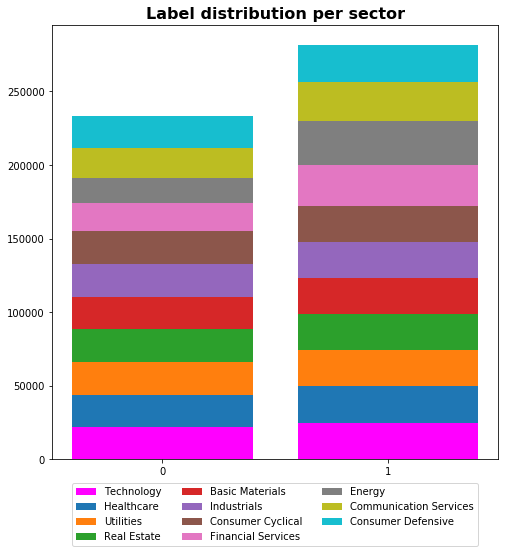

In [229]:
colors = ['tab:blue',
          'tab:orange',
          'tab:green',
          'tab:red',
          'tab:purple',
          'tab:brown',
          'tab:pink',
          'tab:gray',
          'tab:olive',
          'tab:cyan',
          'lime',
          'magenta']

fig,ax = plt.subplots(figsize=(8,8))
y_offset = np.zeros(y[0].unique().shape[0])#0

# Unique Sectors
uniqueSectors = X.sector.unique() 

# Empty list to hold data
data_ls = []

for i,us in enumerate(uniqueSectors):
    
    t, c = np.unique(y[X.sector==us],return_counts = True)
    
    ax.bar(t,c,
           color = colors[i-1],
           bottom = y_offset,label=us)
    
    y_offset = y_offset + c

plt.legend(loc='lower center',
#            mode='expand',
           ncol=3,
           bbox_to_anchor = (0.5,-0.21),
          )#(1,0,0,0)
plt.title('Label distribution per sector',fontweight='bold',fontsize=16)
plt.xticks(t)
plt.show()

In [230]:
uniqueSectors = X.sector.unique() 
for i,us in enumerate(uniqueSectors):
#     print(y[X.sector==us])
    t, c = np.unique(y[X.sector==us],return_counts = True)
    
    if i == 0:
        print(t,'\n\n',us,': ',c,'\n',(c/sum(c)).round(3))
    else:
        print(us,': ',c,'\n',(c/sum(c)).round(3),'\n')
    

[0. 1.] 

 Technology :  [21979 24809] 
 [0.47 0.53]
Healthcare :  [21590 25198] 
 [0.461 0.539] 

Utilities :  [22573 24215] 
 [0.482 0.518] 

Real Estate :  [22434 24354] 
 [0.479 0.521] 

Basic Materials :  [21840 24948] 
 [0.467 0.533] 

Industrials :  [22584 24204] 
 [0.483 0.517] 

Consumer Cyclical :  [22193 24595] 
 [0.474 0.526] 

Financial Services :  [18875 27913] 
 [0.403 0.597] 

Energy :  [17458 29330] 
 [0.373 0.627] 

Communication Services :  [19798 26990] 
 [0.423 0.577] 

Consumer Defensive :  [22023 24765] 
 [0.471 0.529] 



## Investigating why the labels are uneven distributed

In [25]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  123.950  124.110  123.910  124.100         0.02         0.07   
         386  124.085  124.085  123.920  123.995         0.01         0.06   
         387  123.995  124.355  123.985  124.335         0.01         0.07   
         388  124.335  124.355  124.060  124.075         0.05         0.12   
         389  124.075  124.225  122.810  123.855         0.01         2.43   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.01          0.04           1.0          11.0   
         386        0.01          0.01           1.0           8.0   
         387        0.01          0.05           4.0          16.0   
         388        0.01          0.01           3.0           6.0   
         389        0.01          0.21           1.0          20.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            1.0           5.0           9.0   
         386          1.0            3.0           1.0           9.0   
         387          1.0            2.0           2.0          10.0   
         388          1.0            2.0           2.0          10.0   
         389          1.0            2.0           4.0          12.0   

              ofrsize_low  ofrsize_close Ticker  
20200501 0            1.0            4.0   AAPL  
         1            1.0            1.0   AAPL  
         2            1.0            1.0   AAPL  
         3            1.0            1.0   AAPL  
         4            1.0            1.0   AAPL  
...                   ...            ...    ...  
20200529 385          1.0            1.0    WMT  
         386          1.0            2.0    WMT  
         387          1.0            2.0    WMT  
         388          1.0            4.0    WMT  
         389          1.0            1.0    WMT  

[514800 rows x 17 columns]

In [26]:
price_candles[price_candles.Ticker=='AAPL']

open     high      low    close Ticker
20200501 0    286.250  289.260  285.870  289.260   AAPL
         1    289.260  289.350  288.365  289.020   AAPL
         2    289.035  289.705  288.280  288.580   AAPL
         3    288.485  289.315  288.280  289.095   AAPL
         4    289.100  290.435  288.940  290.320   AAPL
...               ...      ...      ...      ...    ...
20200529 385  319.255  319.415  318.830  319.095   AAPL
         386  319.095  319.295  318.810  318.845   AAPL
         387  318.845  319.605  318.695  319.460   AAPL
         388  319.465  319.555  318.660  318.675   AAPL
         389  318.675  319.380  317.500  317.920   AAPL

[7800 rows x 5 columns]

In [27]:
price_candles[price_candles.Ticker=='AAPL']['close'].values

array([289.26 , 289.02 , 288.58 , ..., 319.46 , 318.675, 317.92 ])

In [28]:
extract_labels_multi(price_candles[price_candles.Ticker=='AAPL']['close'].values,classes = 4)

array([0., 0., 3., ..., 3., 0., 0.])

In [29]:
np.unique(extract_labels_multi(price_candles[price_candles.Ticker=='AAPL']['close'].values,classes = 4),return_counts=True)

(array([0., 1., 2., 3.]), array([1950, 1950, 1950, 1949], dtype=int64))

## Investigating across all tickers

In [30]:
for ut in uniqueTickers:
#     print(price_candles[price_candles.Ticker==us].shape)
    t,c = np.unique(extract_labels_multi(price_candles[price_candles.Ticker==ut]['close'].values,
                                         classes = 4),
                    return_counts=True)
    
    print(ut,': ',c)

AAPL :  [1950 1950 1950 1949]
ABBV :  [1950 1746 2154 1949]
ABT :  [1950 1761 2139 1949]
AEP :  [1950 1890 2010 1949]
AMT :  [1950 1858 2042 1949]
APD :  [1950 1870 2030 1949]
BA :  [1950 1872 2028 1949]
BABA :  [1950 1899 2001 1949]
BAC :  [1949 1100 2796 1954]
BHP :  [1950 1308 2592 1949]
BP :  [1947 1020 2882 1950]
CCI :  [1950 1849 2051 1949]
CHL :  [1949 1001 2898 1951]
COST :  [1950 1860 2040 1949]
CSGP :  [1950 1617 2283 1949]
D :  [1950 1817 2083 1949]
DIS :  [1950 1796 2104 1949]
ECL :  [1950 1950 1950 1949]
ENB :  [1950 1258 2638 1953]
EXC :  [1950 1492 2408 1949]
FB :  [1950 1950 1950 1949]
FMX :  [1950 1615 2285 1949]
GOOG :  [1950 1950 1950 1949]
IDU :  [1950 1949 1951 1949]
INTC :  [1949 1577 2324 1949]
IYC :  [1950 1798 2102 1949]
IYE :  [1946 1099 2805 1949]
IYG :  [1950 1766 2134 1949]
IYH :  [1950 1800 2100 1949]
IYJ :  [1950 1708 2192 1949]
IYK :  [1949 1736 2165 1949]
IYM :  [1950 1712 2188 1949]
IYR :  [1950 1663 2236 1950]
IYW :  [1950 1950 1950 1949]
IYZ :  [1943

In [120]:
np.sort(returns)

array([-0.98475044, -0.75034838, -0.71846282, ...,  1.35613928,
        2.76560633,  2.79889807])

In [121]:
np.array_split(np.sort(returns), 4)

[array([-0.98475044, -0.75034838, -0.71846282, ..., -0.0486766 ,
        -0.04861449, -0.04859611]),
 array([-0.04859349, -0.04858562, -0.048583  , ...,  0.        ,
         0.        ,  0.        ]),
 array([0.        , 0.        , 0.        , ..., 0.04930696, 0.04942339,
        0.04943425]),
 array([0.04943968, 0.0494424 , 0.04944512, ..., 1.35613928, 2.76560633,
        2.79889807])]

In [122]:
classes

2268

In [153]:
print(np.array_split(np.sort(returns), classes)[0],'\n\n',
        np.array_split(np.sort(returns), classes)[0].min(),'\n',
        np.array_split(np.sort(returns), classes)[0].max())

[-0.98475044 -0.75034838 -0.71846282 ... -0.0486766  -0.04861449
 -0.04859611] 

 -0.9847504361037651 
 -0.04859611231100569


In [163]:
subData = price_candles[price_candles.Ticker=='ABBV']['close'].values
classes = 4

returns = ((subData[1:] / subData[:-1]) -1) * 100

labels = np.zeros(returns.shape[0])

# print([np.array_split(np.sort(returns), classes)[i] for i in np.arange(classes)])

thresholdsMin = [np.array_split(np.sort(returns), classes)[i].min() for i in np.arange(classes)]
thresholdsMax = [np.array_split(np.sort(returns), classes)[i].max() for i in np.arange(classes)]

print(thresholdsMin,'\n',thresholdsMax)

for i in np.arange(classes):
    if i == 0:
        labels[(returns <= thresholdsMax[i])] = i

    elif i == (classes-1):
        labels[(returns > thresholdsMin[i])] = i

    else:
        labels[(returns > thresholdsMin[i]) & (returns <= thresholdsMax[i])] = i


[-0.9847504361037651, -0.048593488472548074, 0.0, 0.04943968358601669] 
 [-0.04859611231100569, 0.0, 0.04943425244425814, 2.798898071625344]


In [164]:
labels

array([3., 0., 3., ..., 0., 3., 0.])

In [165]:
np.unique(labels,return_counts=True)

(array([0., 1., 2., 3.]), array([1952, 2020, 1879, 1948], dtype=int64))

In [166]:
returns[labels==0]

array([-0.58096869, -0.05518764, -0.27514522, ..., -0.08719821,
       -0.07004688, -0.16155959])

In [147]:
sum(returns==0)

275

In [168]:
print(returns[(returns< thresholdsMin[1])&(returns< thresholdsMax[1])],'\n\n',
      returns[(returns< thresholdsMin[1])&(returns< thresholdsMax[1])].shape)

[-0.58096869 -0.05518764 -0.27514522 ... -0.08719821 -0.07004688
 -0.16155959] 

 (1950,)


In [203]:
# which = 2
# print('Min: ',thresholdsMin[which],'\n',
#       'Max: ',thresholdsMax[which],'\n\n',
#       returns[(returns > thresholdsMin[which])&(returns<= thresholdsMax[which])],'\n',
#       np.sort(returns[(returns > thresholdsMin[which])&(returns<= thresholdsMax[which])]).round(6),'\n\n',
# #       returns[(returns> )&(returns<= thresholdsMax[which])],'\n\n',
#       returns[(returns> thresholdsMin[which])&(returns<= thresholdsMax[which])].shape)
which = 1
# tempSeries = returns[(returns > 0.0)&(returns<= thresholdsMax[which])]
# tempSeries = returns[(returns > thresholdsMin[which])&(returns<= thresholdsMax[which])]
tempSeries = returns[(returns > thresholdsMin[which])&(returns<= -0.0000001)]
print('Min: ',thresholdsMin[which],'\n',
      'Max: ',thresholdsMax[which],'\n\n',
      tempSeries,'\n',
      np.sort(tempSeries).round(10),'\n\n',
#       returns[(returns> )&(returns<= thresholdsMax[which])],'\n\n',
      tempSeries.shape)

Min:  -0.048593488472548074 
 Max:  0.0 

 [-0.01224965 -0.03673769 -0.02440215 ... -0.0218627  -0.00545762
 -0.016254  ] 
 [-0.04858562 -0.048583   -0.04855678 ... -0.00537981 -0.0053582
 -0.00535275] 

 (1738,)


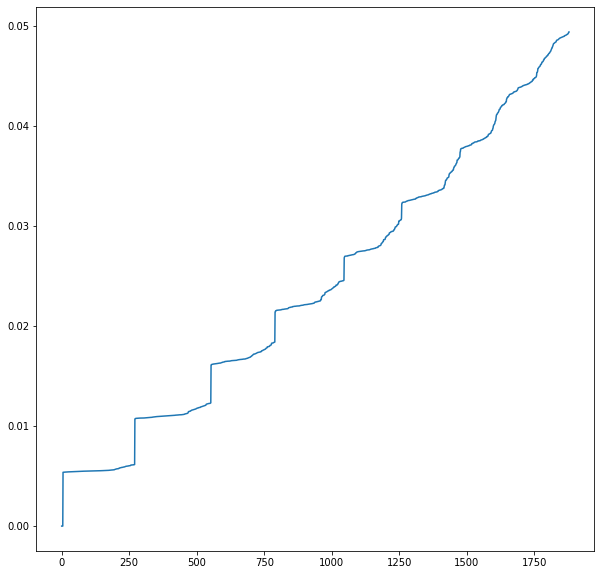

In [190]:
plt.figure(figsize=(10,10))
plt.plot(np.sort(returns[(returns > thresholdsMin[which])&(returns<= thresholdsMax[which])]))
plt.show()

In [207]:
class0 = np.array_split(np.sort(returns),4)[0]
class1 = np.array_split(np.sort(returns),4)[1]
class2 = np.array_split(np.sort(returns),4)[2]
class3 = np.array_split(np.sort(returns),4)[3]

# [np.array_split(np.sort(returns),4)[i].shape for i in np.arange(4)]

In [215]:
np.isin(returns,class3)

array([ True, False,  True, ..., False,  True, False])

In [223]:
np.random.normal(0,1)/1000000

6.402904043842307e-07

In [246]:
subData = price_candles[price_candles.Ticker=='ABBV']['close'].values
classes = 4

returns = ((subData[1:] / subData[:-1]) -1) * 100
returns[returns==0] = np.random.normal(0,1,sum(returns==0))/1000000
labels_1 = np.zeros(returns.shape[0])

# print([np.array_split(np.sort(returns), classes)[i] for i in np.arange(classes)])

# thresholdsMin = [np.array_split(np.sort(returns), classes)[i].min() for i in np.arange(classes)]
# thresholdsMax = [np.array_split(np.sort(returns), classes)[i].max() for i in np.arange(classes)]

splits = np.array_split(np.sort(returns),4)

# print(thresholdsMin,'\n',thresholdsMax)

for i in np.arange(classes):
    print(splits[i].shape)
    #     if i == 0:
#         labels[(returns <= thresholdsMax[i])] = i

#     elif i == (classes-1):
#         labels[(returns > thresholdsMin[i])] = i

#     else:
#         labels[(returns > thresholdsMin[i]) & (returns <= thresholdsMax[i])] = i
    labels_1[np.isin(returns,splits[i])] = i


(1950,)
(1950,)
(1950,)
(1949,)


In [247]:
np.unique(labels_1,return_counts=True)

(array([0., 1., 2., 3.]), array([1950, 1950, 1950, 1949], dtype=int64))

In [226]:
returns[returns==0]

array([], dtype=float64)

In [241]:
np.random.normal(0,1,sum(returns==0))/100000

array([-9.40904681e-07,  9.15898926e-06,  7.65129312e-06,  1.53871636e-05,
        7.81663533e-06,  1.11229918e-06,  1.61803359e-05,  2.58548514e-06,
       -2.70466233e-06, -3.61493823e-06, -3.19051319e-06,  3.89439626e-06,
       -1.24871888e-05,  3.80702077e-06, -3.17358242e-06,  5.31251041e-06,
        7.88258454e-06, -1.56041682e-05,  2.44436889e-05,  3.37275605e-06,
       -1.39533175e-05, -8.68422835e-07,  6.51059414e-06, -7.94187134e-07,
       -1.41864340e-05,  1.55609623e-05, -3.59696774e-06,  8.96766295e-07,
        6.05238666e-07, -4.34936858e-06, -2.81680595e-06, -1.28537763e-05,
       -4.19550002e-06,  2.63312392e-05, -5.19619830e-06,  1.64064893e-05,
        3.87038719e-06,  1.08567236e-05, -4.44385421e-06,  2.28757065e-05,
        5.33042728e-06,  1.81093151e-06, -3.01174787e-06,  8.19713187e-06,
        7.58688571e-06, -6.15794845e-06, -6.69504743e-06,  2.85066480e-05,
        9.29231502e-07,  1.18933686e-05, -5.82187038e-06,  4.39108645e-06,
        1.75051352e-05,  

In [237]:
returns[returns==0] = np.random.normal(0,1,sum(returns==0))/1000

In [ ]:
def extract_labels_multi(data = None,
                        classes = 5,
                        group_style = 'equal',
                        splits=None):

   # returns = ((data.T[-1][1:]/data.T[-1][0:-1])-1)*100
    returns = ((data[1:] / data[:-1]) -1) * 100
    # If returns are exact zero, perhaps because there hasn't been any price updates over a candle, we add a little bit of noise, to ensure that the labels are evenly distributed.
    returns[returns==0] = np.random.normal(0,1,sum(returns==0))/1000000

    labels = np.zeros(returns.shape[0])

    if group_style == 'equal':
        if splits is None:
            splits = np.array_split(np.sort(returns),classes)

        for i in np.arange(classes):

            labels[np.isin(returns,splits[i])] = i

    elif group_style != 'equal':
        raise ValueError(f'group_style {group_style} not implemented')

    return labels #, returns, [thresholdsMin, thresholdsMax]

In [61]:
data

array([289.26 , 289.02 , 288.58 , ..., 124.335, 124.075, 123.855])

In [62]:
returns = np.concatenate([((price_candles[price_candles.Ticker==ticker]['close'].values[1:]/\
                         price_candles[price_candles.Ticker==ticker]['close'].values[:-1])-1) for ticker\
                          in price_candles.Ticker.unique()])

In [63]:
returns.shape

(514734,)

In [24]:
data = price_candles['close'].values#[price_candles.Ticker=='ABBV']

In [25]:
data.shape

(514800,)

In [69]:
# returns = ((data.T[-1][1:]/data.T[-1][0:-1])-1)*100
# returns = ((data[1:] / data[:-1]) -1) * 100
# returns = ((data[1:] / data[:-1]) -1) * 100
# If returns are exact zero, perhaps because there hasn't been any price updates over a candle, we add a little bit of noise, to ensure that the labels are evenly distributed.
returns[returns==0] = np.random.normal(0,1,sum(returns==0))/1000000
classes = 2
labels = np.zeros(returns.shape[0])

# if group_style == 'equal':
#     if splits is None:
splits = np.array_split(np.sort(returns),classes)

for i in np.arange(classes):

    labels[np.isin(returns,splits[i])] = i

# elif group_style != 'equal':
#     raise ValueError(f'group_style {group_style} not implemented')

#     return labels #, returns, [thresholdsMin, thresholdsMax]

In [65]:
labels.shape

(514734,)

In [66]:
splits[0].shape

(257367,)

In [67]:
splits[1].shape

(257367,)

In [70]:
np.unique(labels,return_counts=True)

(array([0., 1.]), array([257367, 257367], dtype=int64))

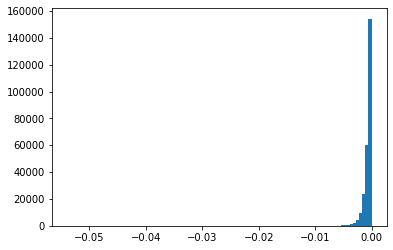

In [71]:
plt.hist(splits[0],bins=100)
plt.show()

In [72]:
splits[0].min(),splits[1].min(),splits[0].max(),splits[1].max()

(-0.053926348158703896,
 1.9029269130544944e-08,
 1.899349586016317e-08,
 0.0907158043940468)

In [73]:
returns.min(),returns.max()

(-0.053926348158703896, 0.0907158043940468)

In [34]:
def extract_labels_multi(data = None,
                        classes = 5,
                        group_style = 'equal',
                        splits=None):

   # returns = ((data.T[-1][1:]/data.T[-1][0:-1])-1)*100
    returns = ((data[1:] / data[:-1]) -1) * 100
    # If returns are exact zero, perhaps because there hasn't been any price updates over a candle, we add a little bit of noise, to ensure that the labels are evenly distributed.
    returns[returns==0] = np.random.normal(0,1,sum(returns==0))/1000000

    labels = np.zeros(returns.shape[0])

    if group_style == 'equal':
        if splits is None:
            splits = np.array_split(np.sort(returns),classes)

        for i in np.arange(classes):

            labels[np.isin(returns,splits[i])] = i

    elif group_style != 'equal':
        raise ValueError(f'group_style {group_style} not implemented')

    return labels #, returns, [thresholdsMin, thresholdsMax]

In [35]:
X.columns

Index(['open_lag0', 'high_lag0', 'low_lag0', 'close_lag0', 'spread_open_lag0',
       'spread_high_lag0', 'spread_low_lag0', 'spread_close_lag0',
       'bidsize_open_lag0', 'bidsize_high_lag0', 'bidsize_low_lag0',
       'bidsize_close_lag0', 'ofrsize_open_lag0', 'ofrsize_high_lag0',
       'ofrsize_low_lag0', 'ofrsize_close_lag0', 'open_lag1', 'high_lag1',
       'low_lag1', 'close_lag1', 'spread_open_lag1', 'spread_high_lag1',
       'spread_low_lag1', 'spread_close_lag1', 'bidsize_open_lag1',
       'bidsize_high_lag1', 'bidsize_low_lag1', 'bidsize_close_lag1',
       'ofrsize_open_lag1', 'ofrsize_high_lag1', 'ofrsize_low_lag1',
       'ofrsize_close_lag1', 'ticker', 'sector'],
      dtype='object')

In [40]:
sum_0 = 0
sum_1 = 0
for ticker in X.ticker.unique():
#     temp = price_candles[price_candles.Ticker==ticker]['close'].values#
    t, c = np.unique(extract_labels_multi(price_candles[price_candles.Ticker==ticker]['close'].values,
                         2,
                         'equal',
                         splits),return_counts=True)
    print(t,c)
    sum_0 += c[0]
    sum_1 += c[1]

[0. 1.] [3880 3919]
[0. 1.] [3988 3811]
[0. 1.] [4040 3759]
[0. 1.] [4108 3691]
[0. 1.] [3948 3851]
[0. 1.] [4037 3762]
[0. 1.] [3934 3865]
[0. 1.] [4005 3794]
[0. 1.] [4755 3044]
[0. 1.] [4513 3286]
[0. 1.] [4968 2831]
[0. 1.] [3951 3848]
[0. 1.] [4974 2825]
[0. 1.] [3955 3844]
[0. 1.] [4173 3626]
[0. 1.] [4075 3724]
[0. 1.] [3942 3857]
[0. 1.] [3874 3925]
[0. 1.] [4573 3226]
[0. 1.] [4394 3405]
[0. 1.] [3862 3937]
[0. 1.] [4324 3475]
[0. 1.] [3816 3983]
[0. 1.] [4100 3699]
[0. 1.] [4256 3543]
[0. 1.] [3952 3847]
[0. 1.] [4828 2971]
[0. 1.] [3974 3825]
[0. 1.] [3968 3831]
[0. 1.] [3964 3835]
[0. 1.] [4121 3678]
[0. 1.] [4039 3760]
[0. 1.] [4188 3611]
[0. 1.] [3831 3968]
[0. 1.] [5160 2639]
[0. 1.] [4085 3714]
[0. 1.] [4569 3230]
[0. 1.] [7070  729]
[0. 1.] [3965 3834]
[0. 1.] [3958 3841]
[0. 1.] [3919 3880]
[0. 1.] [4000 3799]
[0. 1.] [3928 3871]
[0. 1.] [4002 3797]
[0. 1.] [3909 3890]
[0. 1.] [4202 3597]
[0. 1.] [5803 1996]
[0. 1.] [4073 3726]
[0. 1.] [4841 2958]
[0. 1.] [4070 3729]


In [41]:
sum_0,sum_1

(280922, 233812)

In [44]:
returns.shape

(514799,)

In [58]:
global_median = np.median(returns)

In [59]:
global_median

0.0

In [ ]:
sum_0 = 0
sum_1 = 0
for ticker in X.ticker.unique():
#     temp = price_candles[price_candles.Ticker==ticker]['close'].values#
    t, c = np.unique(extract_labels_multi(price_candles[price_candles.Ticker==ticker]['close'].values,
                         2,
                         'equal',
                         splits),return_counts=True)
    print(t,c)
    sum_0 += c[0]
    sum_1 += c[1]

In [322]:
# Random
tt = pd.DataFrame({'a': [0,1,2], 'b': ['TSLA', 'AAPL', 'TSLA']})
tt

,a,b
0,0,TSLA
1,1,AAPL
2,2,TSLA


In [336]:
tt.groupby('b').size() #to_csv('WHATSUP.csv', header=False)

b
AAPL    1
TSLA    2
dtype: int64

In [341]:
with open('kalkun.txt', 'a+') as file:
    file.write('\n|\nAAPL\n')
    file.write(str(tt.groupby('b').size()))

In [328]:
tt.groupby('b').size().idxmax()

'TSLA'

In [329]:
tt[tt.b == tt.groupby('b').size().idxmax()]

,a,b
0,0,TSLA
2,2,TSLA
